## Comprensión de lenguaje natural para sinopsis

### Introducción

En este *notebook* vamos a probar diversas técnicas de NLP para transformar una sinopsis de un libro en un vector que sirva de input para nuestro posterior modelo del sistema de recomendación. Trataremos de interpretar qué significado tienen esos vectores o cuáles han sido las técnicas utilizadas para darles esa forma.

Antes de empezar, instalaremos las librerías necesarias para las tareas a realizar. Se recomienda instalar en un entorno de ejecución no local, con GPU disponible. En nuestro caso, lo haremos con [*Google Colab*](https://colab.research.google.com).

In [2]:
%%capture
!pip3 install seaborn
!pip3 install -U spacy
!python3 -m spacy download en_core_web_lg
!pip3 install -U transformers
!pip3 install -U sentence-transformers

También montaremos nuestro *Google Drive*, en el que tenemos varios ficheros de texto para las sinopsis de ejemplo que usaremos para las pruebas.

In [3]:
# Monta Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

# Crea un soft link de la carpeta con las sinopsis
!ln -s /content/gdrive/MyDrive/Colab\ Notebooks/TFG_SR_Libros/summaries .

Mounted at /content/gdrive


### Word embeddings

Usaremos, en principio, la librería NLP `spacy`. En su caso, y como la gran mayoría de sinopsis de los libros de que disponemos son en inglés, utilizaremos el modelo (*pipeline*) `en_core_web_lg`. Hemos escogido la versión grande del modelo puesto que para la transformación de *tokens* de texto en vectores, cuenta con mucha más información precomputada para el cálculo de los mismos, además de ser más efectivo.

Mostramos un primer ejemplo en el que analizamos la sinopsis extraída de *GoodReads* del libro *The Dispossessed*, escrito por Ursula K. Le Guin.

In [4]:
import os
import spacy

# Lee la sinopsis de un libro
with open(os.path.join("summaries", "dispossessed.txt"), "r") as f:
    dispossessed_summary = f.read()

# Carga el modelo de spacy y tokeniza la sinopsis
nlp = spacy.load("en_core_web_lg")
dispossessed_tokens = nlp(dispossessed_summary)

# Imprime información sobre cada token y el potencial vector asociado
for token in dispossessed_tokens:
    print(token.text, token.has_vector, token.vector_norm, token.is_oov)

Shevek False 0.0 True
, True 64.72698 False
a True 112.98545 False
brilliant True 26.414904 False
physicist True 38.49606 False
, True 64.72698 False
decides True 40.19985 False
to True 125.107445 False
take True 67.411446 False
action True 63.787525 False
. True 59.90988 False
He True 127.80685 False
will True 67.574356 False
seek True 61.793026 False
answers True 41.63712 False
, True 64.72698 False
question True 45.032265 False
the True 72.329216 False
unquestionable True 28.41399 False
, True 64.72698 False
and True 60.75837 False
attempt True 47.164364 False
to True 125.107445 False
tear True 54.97283 False
down True 69.28324 False
the True 72.329216 False
walls True 58.260063 False
of True 120.9016 False
hatred True 40.90178 False
that True 57.417362 False
have True 61.392063 False
isolated True 40.373966 False
his True 95.241104 False
planet True 48.34115 False
of True 120.9016 False
anarchists True 33.042927 False
from True 58.585716 False
the True 72.329216 False
rest True 48.

Como vemos, la gran mayoría de *tokens* tienen un vector asociado, del que incluimos su norma L2 (la norma euclídea). Es llamativo cómo el primer *token*, referente a la palabra *Shevek*, no tiene información sobre un vector. Como indica el atributo `is_oov` (*out of vocabulary*), no es una palabra reconocible dentro del idioma inglés. Es lógico, pues se trata del protagonista de la novela, el cual procede de un planeta de otro sistema solar.

Podemos comparar también entre dos textos según su similitud. En este ejemplo, incluimos también la sinopsis del libro *The Moon is a Harsh Mistress*, de Robert A. Heinlein. Ambos libros comparten temas como sociedades utópicas, sistemas alternativos y reflexiones sobre la revolución, además de desarrollarse en lugares típicos de la ciencia ficción como pueden ser la Luna o un planeta imaginario.

In [5]:
# Lee la sinopsis del segundo libro
with open(os.path.join("summaries", "harsh_mistress.txt"), "r") as f:
    harsh_mistress_summary = f.read()

# Tokeniza la sinopsis
harsh_mistress_tokens = nlp(harsh_mistress_summary)

# Calcula la similitud entre las sinopsis
print(dispossessed_tokens.similarity(harsh_mistress_tokens))

0.928204041678369


Según la documentación de `spaCy`, para obtener la similitud se computa un vector de medias para cada uno de los textos a ser comparados a partir de los vectores precomputados referidos a las palabras de forma individual. Así, el orden en que aparezcan las palabras dentro del texto no influye en el resultado.

Además, dos textos que hablen de lo mismo pero que empleen palabras muy diferentes podrían tener un grado de similitud bajo. Por el contrario, si dos textos no necesariamente parecidos en contenido sí cuentan con una redacción similar, esto es, comparten un número importante de palabras, pueden obtener un grado de similitud elevado.

Vamos a comparar con una sinopsis de un libro de temática diferente para comprobar de nuevo esta métrica. Por ejemplo, probemos con *Wuthering Heights*, de Emily Brontë.

In [6]:
# Lee la sinopsis del tercer libro
with open(os.path.join("summaries", "wuthering.txt"), "r") as f:
    wuthering_summary = f.read()

# Tokeniza la sinopsis
wuthering_tokens = nlp(wuthering_summary)

# Calcula la similitud entre las sinopsis
print(dispossessed_tokens.similarity(wuthering_tokens))
print(harsh_mistress_tokens.similarity(wuthering_tokens))

0.8808052534232476
0.9473500192848667


La similitud sigue siendo bastante alta a pesar de lo diferentes que son los libros en cuanto a su contenido.

Por tanto, podemos deducir que no sólo nos hace falta una representación vectorial "plana" de aquellas palabras que aparecen en una sinopsis de un libro en particular, sino que tendremos que aplicar técnicas algo más sofisticadas para dotar de significado a los textos y convertirlos en vectores que se adecuen más al contenido de estos. Esto es, actuar sobre la semántica de frases y textos cortos como un todo en el que el contexto y la semántica son tenidos en cuenta.

### Sentence Transformers

#### BERT (Bidirectional Encoder Representations from Transformers)

Para capturar el contenido semántico de un texto, frase a frase, interpretando su contexto, emplearemos una técnica de *Deep Learning* para el procesamiento de lenguaje natural, creada originalmente por *Google* entre los años 2018 y 2019. A partir de [*Transformers*](https://en.wikipedia.org/wiki/Transformer_(machine_learning_model)), convertirá nuestras sinopsis en vectores de alta dimensión, esta vez teniendo en cuenta la parte por el todo.

Probemos con [SBERT](https://www.sbert.net/), estado del arte para transformación de oraciones en vectores de alta dimensión. Vamos a comprobar el resultado de varios de los modelos ya entrenados disponibles en la librería `sentence-transformers`. La idea detrás de SBERT es el uso de [redes BERT Siamesas](https://arxiv.org/abs/1908.10084).

Con esto, podremos calcular la similitud entre dos textos mediante la similitud coseno, tratando a cada uno de nuestros textos como vectores de un espacio euclídeo de dimensión elevada (el coseno del ángulo entre estos vectores nos dará una idea de la semejanza según su dirección y sentido).

In [8]:
from sentence_transformers import SentenceTransformer, util
import numpy as np

# Cargamos el modelo BERT pre-entrenado
bert_model = SentenceTransformer('all-MiniLM-L12-v2')

# Codificamos las sinopsis en vectores (embeddings en un único tensor)
book_summaries = [dispossessed_summary, harsh_mistress_summary, wuthering_summary]
encoded_book_summaries = bert_model.encode(book_summaries, convert_to_tensor=True)

def pretty_print_embeddings(embeddings, labels):
    """
    Imprime los embeddings de cada libro
    """
    for i, embedding in enumerate(list(embeddings)):
        print("Libro: {}".format(labels[i]))
        print("Tamaño del embedding: {}".format(len(embedding)))
        embedding_snippet = ", ".join(("{}".format(x) for x in embedding[:3]))
        print("Embedding: [{}, ...]\n".format(embedding_snippet))

# Representación de los embeddings
titles = ['The Dispossessed', 'The Moon is a Harsh Mistress', 'Wuthering Heights']
pretty_print_embeddings(encoded_book_summaries, titles)

# Calculamos la similitud entre las sinopsis (matriz de cosine similarity)
print(util.cos_sim(encoded_book_summaries, encoded_book_summaries))

Libro: The Dispossessed
Tamaño del embedding: 384
Embedding: [-0.13699674606323242, -0.009759328328073025, -0.030589718371629715, ...]

Libro: The Moon is a Harsh Mistress
Tamaño del embedding: 384
Embedding: [0.022966111078858376, 0.06298079341650009, -0.07083865255117416, ...]

Libro: Wuthering Heights
Tamaño del embedding: 384
Embedding: [-0.019249169155955315, -0.0018341043032705784, -0.03787386789917946, ...]

tensor([[1.0000, 0.3629, 0.1810],
        [0.3629, 1.0000, 0.2829],
        [0.1810, 0.2829, 1.0000]], device='cuda:0')


Para una representación más visual, podemos considerar un gráfico de calor que muestre la matriz de similitudes. Se usa la librería `seaborn`. Se ha tomado como partida el código disponible en el [tutorial](https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder) de *Google* sobre USE, un modelo del que hablaremos más adelante.

tensor([[1.0000, 0.3629, 0.1810],
        [0.3629, 1.0000, 0.2829],
        [0.1810, 0.2829, 1.0000]])


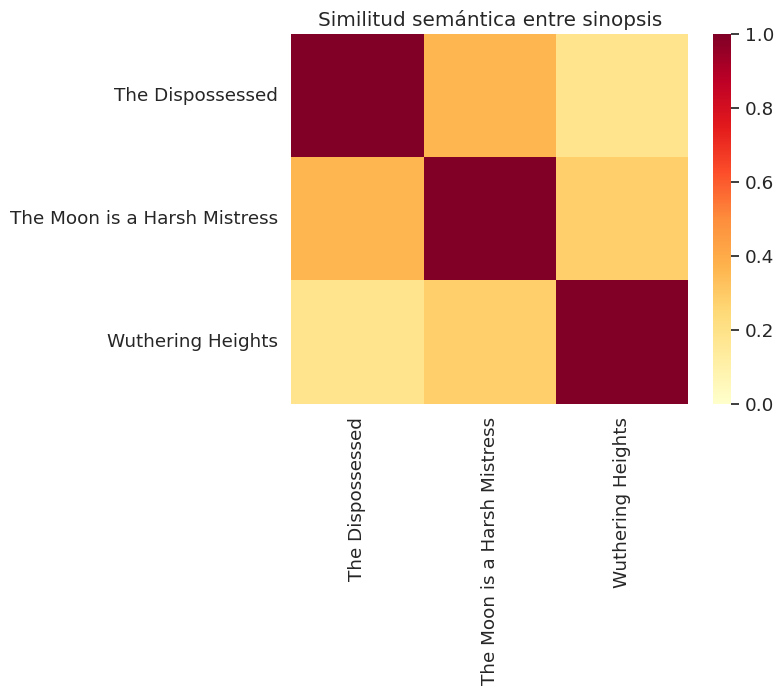

In [9]:
import seaborn as sns

def plot_similarity(features, labels, plt_title, rotation, similarity):
    """
    Representa la similitud entre embeddings con un mapa de calor
    """
    corr = similarity(features, features)
    print(corr)
    sns.set(font_scale=1.2)
    g = sns.heatmap(
        corr,
        xticklabels=labels,
        yticklabels=labels,
        vmin=0,
        vmax=1,
        cmap="YlOrRd"
    )
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title(plt_title)

plot_similarity(encoded_book_summaries.detach().cpu(), titles, "Similitud semántica entre sinopsis", 90, util.cos_sim)

Para realizar las pruebas con una mayor muestra de sinopsis y tener un resultado más visible, vamos a comparar los últimos 4 libros de la saga de *Harry Potter* junto con los libros de la saga *L'amica geniale*, de Elena Ferrante. Estas dos sagas son bastante diferentes entre sí, pues *Harry Potter* pertenece al género fantástico, además de ser literatura juvenil; mientras que la obra de Elena Ferrante es narrativa y se desarrolla en la Italia de a partir de los años 40 hasta la actualidad.

Si los modelos NLP han interpretado correctamente las temáticas y el contenido semántico de las sinopsis, deberíamos observar una similitud pronunciada entre los libros de una misma saga, y a su vez una correlación más bien débil entre sagas.

In [10]:
# Lee las sinopsis de la primera saga
book_summaries = []
for i in range(4, 8):
  with open(os.path.join("summaries", "harry{}.txt".format(i)), "r") as f:
    harry_summary = f.read()
  book_summaries.append(harry_summary)

# Lee las sinopsis de la segunda saga
for i in range(1, 5):
  with open(os.path.join("summaries", "ferrante{}.txt".format(i)), "r") as f:
    ferrante_summary = f.read()
  book_summaries.append(ferrante_summary)

# Etiquetas con los títulos de los libros
titles = ["Harry Potter #{}".format(i) for i in range(4, 8)]
titles += ["L'amica geniale #{}".format(i) for i in range(1, 5)]

tensor([[1.0000, 0.7486, 0.6037, 0.3518, 0.0490, 0.1070, 0.0998, 0.0969],
        [0.7486, 1.0000, 0.6426, 0.4875, 0.1500, 0.2176, 0.1905, 0.2298],
        [0.6037, 0.6426, 1.0000, 0.3968, 0.0373, 0.0477, 0.0943, 0.0807],
        [0.3518, 0.4875, 0.3968, 1.0000, 0.1000, 0.2145, 0.1710, 0.2100],
        [0.0490, 0.1500, 0.0373, 0.1000, 1.0000, 0.5956, 0.5693, 0.5018],
        [0.1070, 0.2176, 0.0477, 0.2145, 0.5956, 1.0000, 0.8135, 0.7226],
        [0.0998, 0.1905, 0.0943, 0.1710, 0.5693, 0.8135, 1.0000, 0.7235],
        [0.0969, 0.2298, 0.0807, 0.2100, 0.5018, 0.7226, 0.7235, 1.0000]])


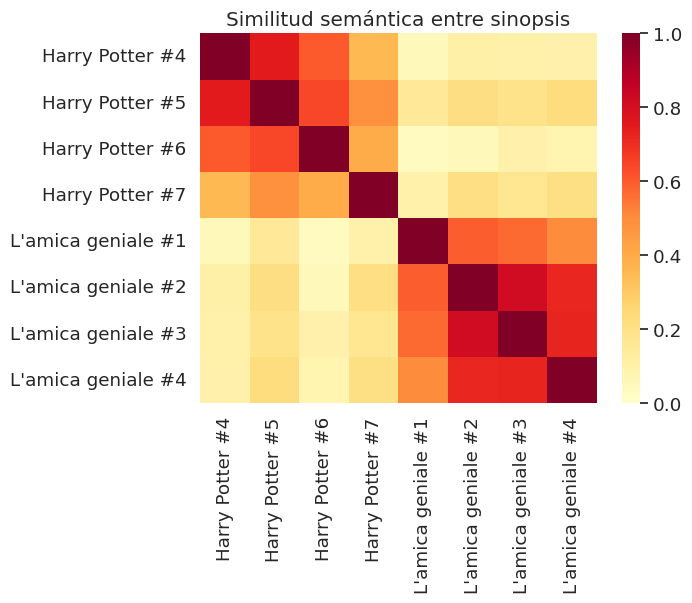

In [12]:
"""
Versión del anterior modelo menos potente, pero mucho más rápida
Embeddings de 384 dimensiones y normalizados
"""
bert_model = SentenceTransformer('all-MiniLM-L6-v2')

# Codificamos las sinopsis en vectores (embeddings en un único tensor)
encoded_book_summaries = bert_model.encode(book_summaries, convert_to_tensor=True)

# Se usa producto escalar al estar los embeddings normalizados
plot_similarity(encoded_book_summaries.detach().cpu(), titles, "Similitud semántica entre sinopsis", 90, util.dot_score)

Como esperábamos, hay dos conglomerados evidentes en el mapa de calor. Se tiene una fuerte relación entre los libros que pertenecen a una misma saga y apenas existe relación entre libros de sagas distintas. Por tanto, parece que este modelo SBERT captura las diferencias semánticas entre sinopsis relativamente bien.

Las tonalidades dentro de un mismo conglomerado varían en función de la relación que pueda existir entre un libro y su continuación. Por ejemplo, tiene sentido que entre los libros 4 y 5 de *Harry Potter* haya una similitud más elevada al ser libros consecutivos y contar eventos muy relacionados. O en el caso de la saga italiana, los libros tercero y cuarto tienen un tono más parecido que el que puede haber entre el primero y el último.

Por supuesto, la forma en la que se relatan las sinopsis también influye, pero en general se ha obtenido un resultado coherente con el esperado.

tensor([[1.0000, 0.6949, 0.6540, 0.5197, 0.0661, 0.0886, 0.0804, 0.0731],
        [0.6949, 1.0000, 0.4906, 0.4139, 0.0658, 0.1246, 0.0542, 0.0732],
        [0.6540, 0.4906, 1.0000, 0.5245, 0.0653, 0.0399, 0.0795, 0.0417],
        [0.5197, 0.4139, 0.5245, 1.0000, 0.1259, 0.1579, 0.1602, 0.1833],
        [0.0661, 0.0658, 0.0653, 0.1259, 1.0000, 0.6731, 0.7686, 0.5567],
        [0.0886, 0.1246, 0.0399, 0.1579, 0.6731, 1.0000, 0.7388, 0.6906],
        [0.0804, 0.0542, 0.0795, 0.1602, 0.7686, 0.7388, 1.0000, 0.6763],
        [0.0731, 0.0732, 0.0417, 0.1833, 0.5567, 0.6906, 0.6763, 1.0000]])


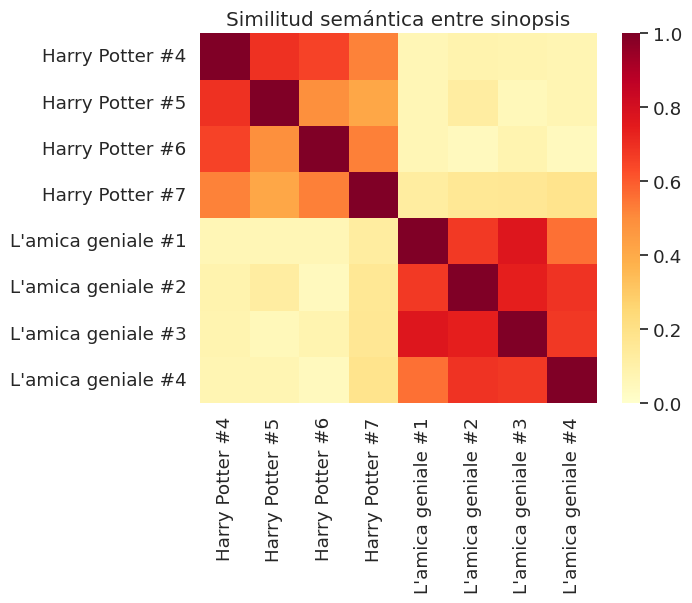

In [14]:
"""
Segundo modelo más potente
768 dimensiones, embeddings normalizados
"""
bert_model = SentenceTransformer('all-distilroberta-v1')

# Codificamos las sinopsis en vectores (embeddings en un único tensor)
encoded_book_summaries = bert_model.encode(book_summaries, convert_to_tensor=True)

# Se usa producto escalar al estar los embeddings normalizados
plot_similarity(encoded_book_summaries.detach().cpu(), titles, "Similitud semántica entre sinopsis", 90, util.dot_score)

Con este modelo, el resultado es incluso más definitivo. Las diferencias entre sagas son muy marcadas y, de hecho, en el caso de la obra de Elena Ferrante, la relación entre libros es muy alta, con una similitud quizá algo más baja entre el primero y el cuarto. Esto tiene todo el sentido del mundo si uno ha leído la obra (el primero se centra principalmente en la etapa de la niñez, mientras que el último libro relata los eventos que sucedieron en la madurez y los años finales de las protagonistas).

tensor([[1.0000, 0.8222, 0.6082, 0.5298, 0.1695, 0.2130, 0.2001, 0.2164],
        [0.8222, 1.0000, 0.6512, 0.4777, 0.2325, 0.2819, 0.2860, 0.2780],
        [0.6082, 0.6512, 1.0000, 0.4439, 0.1257, 0.1176, 0.1075, 0.1350],
        [0.5298, 0.4777, 0.4439, 1.0000, 0.1482, 0.1983, 0.1801, 0.2645],
        [0.1695, 0.2325, 0.1257, 0.1482, 1.0000, 0.7341, 0.8101, 0.6997],
        [0.2130, 0.2819, 0.1176, 0.1983, 0.7341, 1.0000, 0.8092, 0.7836],
        [0.2001, 0.2860, 0.1075, 0.1801, 0.8101, 0.8092, 1.0000, 0.7512],
        [0.2164, 0.2780, 0.1350, 0.2645, 0.6997, 0.7836, 0.7512, 1.0000]])


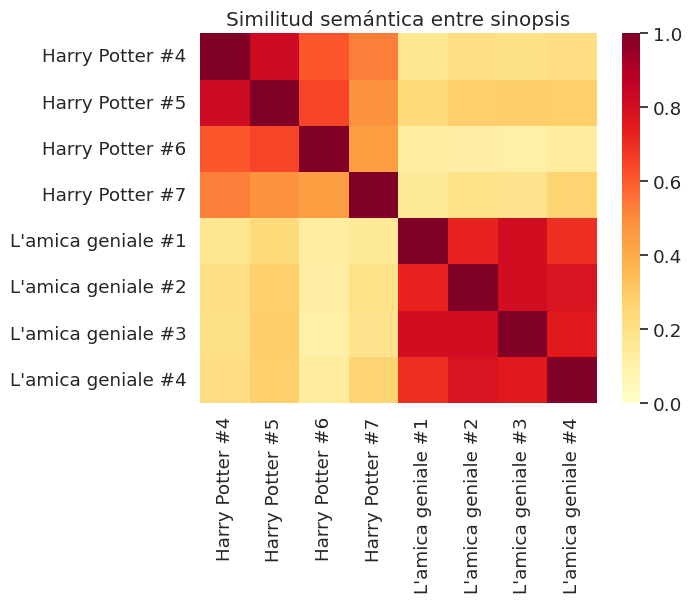

In [16]:
"""
Modelo más potente que actualmente ofrece sentence-transformers
768 dimensiones, embeddings normalizados
"""
bert_model = SentenceTransformer('all-mpnet-base-v2')

# Codificamos las sinopsis en vectores (embeddings en un único tensor)
encoded_book_summaries = bert_model.encode(book_summaries, convert_to_tensor=True)

# Se usa producto escalar al estar los embeddings normalizados
plot_similarity(encoded_book_summaries.detach().cpu(), titles, "Similitud semántica entre sinopsis", 90, util.dot_score)

En este último modelo, los resultados son bastante similares a los dos anteriores, quizás algo más cercano a las similitudes esperables entre los libros de la saga de Harry Potter en comparación con el anterior. También detecta mayor similitud entre sagas.

Así pues, de utilizar SBERT, quizá nos interesen el modelo `all-MiniLM-L6-v2`, más rápido, o el basado en RoBERTa con un proceso de destilación, `all-distilroberta-v1`.

**BONUS:** Un detalle importante es que SBERT también ofrece modelos multilingües pre-entrenados muy potentes, por lo que es posible realizar una comparación de textos en idiomas distintos. Esto nos puede servir por el hecho de que algunas de las sinopsis incluidas en el dataset de los libros están en diversos idiomas, no sólo inglés.

Mostramos un ejemplo con las mismas sinopsis pero en distintos idiomas (inglés, español e italiano) utilizando el modelo `distiluse-base-multilingual-cased-v2`, que admite más de 50 idiomas.

In [17]:
# Lee las sinopsis de la primera saga
multi_lang_book_summaries = []
for i in range(4, 8):
  with open(os.path.join("summaries/multilingual", "harry{}.txt".format(i)), "r") as f:
    harry_summary = f.read()
  multi_lang_book_summaries.append(harry_summary)

# Lee las sinopsis de la segunda saga
for i in range(1, 5):
  with open(os.path.join("summaries/multilingual", "ferrante{}.txt".format(i)), "r") as f:
    ferrante_summary = f.read()
  multi_lang_book_summaries.append(ferrante_summary)

# Etiquetas con los títulos de los libros
titles = ["Harry Potter #{}".format(i) for i in range(4, 8)]
titles += ["L'amica geniale #{}".format(i) for i in range(1, 5)]

tensor([[0.9063, 0.7441, 0.6061, 0.5741, 0.1616, 0.2636, 0.2923, 0.2128],
        [0.7441, 1.0517, 0.6054, 0.6542, 0.1836, 0.2321, 0.2214, 0.1722],
        [0.6061, 0.6054, 0.8079, 0.4958, 0.1184, 0.2311, 0.2657, 0.1643],
        [0.5741, 0.6542, 0.4958, 0.9756, 0.1212, 0.1769, 0.1639, 0.1251],
        [0.1616, 0.1836, 0.1184, 0.1212, 1.0084, 0.3312, 0.5067, 0.3982],
        [0.2636, 0.2321, 0.2311, 0.1769, 0.3312, 0.6730, 0.5256, 0.4342],
        [0.2923, 0.2214, 0.2657, 0.1639, 0.5067, 0.5256, 0.9033, 0.5409],
        [0.2128, 0.1722, 0.1643, 0.1251, 0.3982, 0.4342, 0.5409, 0.6315]])


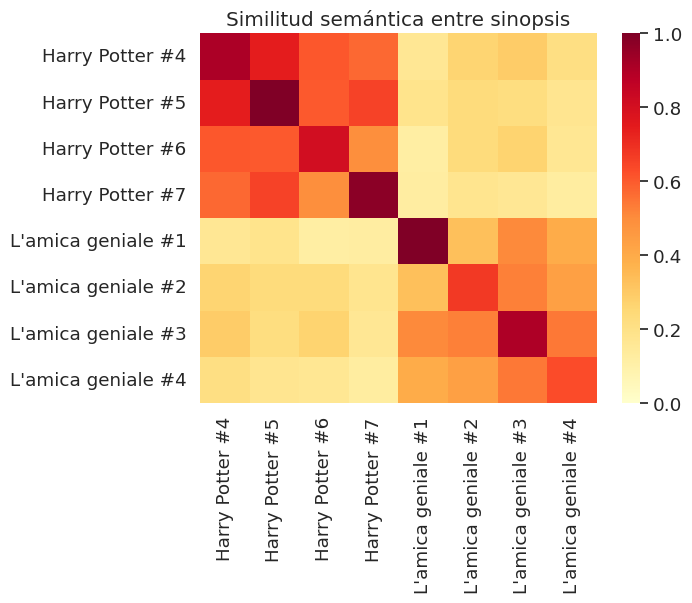

In [21]:
"""
Modelo multilingüe que admite más de 50 idiomas para similitud
semántica entre idiomas
"""
bert_model = SentenceTransformer('distiluse-base-multilingual-cased-v2')

# Codificamos las sinopsis en vectores (embeddings en un único tensor)
encoded_book_summaries = bert_model.encode(multi_lang_book_summaries, convert_to_tensor=True)

# Se usa producto escalar al estar los embeddings normalizados
plot_similarity(encoded_book_summaries.detach().cpu(), titles, "Similitud semántica entre sinopsis", 90, util.dot_score)

En este caso, parece que mantiene las similitudes entre los libros de *Harry Potter*, para los cuales se han incluido dos sinopsis en español (4 y 6) y las otras dos en inglés. Sin embargo, en la saga de *L'amica geniale*, el resultado es bastante más pobre tras incoporar dos sinopsis en italino (libros 2 y 4) y compararlas con las otras dos, que están en inglés.

En base a este análisis, los modelos multilingües son más bien contraproducentes para nuestro objetivo, así que tendremos que centrarnos en aquellos libros con descripción en inglés.

#### USE (Universal Sentence Encoder)

Otro modelo actual para comparación de texto es USE (*Universal Sentence Encoder*), de *Google*. Similar a BERT, actúa tanto sobre frases como piezas de texto enteras, transformándolos en *embeddings*. Veamos qué resultados obtenemos.

[[0.99999976 0.7590967  0.70838666 0.49352884 0.02328001 0.10414712
  0.19331414 0.17943099]
 [0.7590967  1.0000002  0.7287981  0.5656612  0.17020488 0.22630855
  0.25900245 0.26947856]
 [0.70838666 0.7287981  1.         0.5473703  0.09601016 0.12472746
  0.24960554 0.21163821]
 [0.49352884 0.5656612  0.5473703  0.9999999  0.1482403  0.27803695
  0.30674338 0.3462844 ]
 [0.02328001 0.17020488 0.09601016 0.1482403  1.         0.5959642
  0.5344273  0.6125972 ]
 [0.10414712 0.22630855 0.12472746 0.27803695 0.5959642  1.
  0.67699206 0.72279215]
 [0.19331414 0.25900245 0.24960554 0.30674338 0.5344273  0.67699206
  0.9999999  0.6790039 ]
 [0.17943099 0.26947856 0.21163821 0.3462844  0.6125972  0.72279215
  0.6790039  1.        ]]


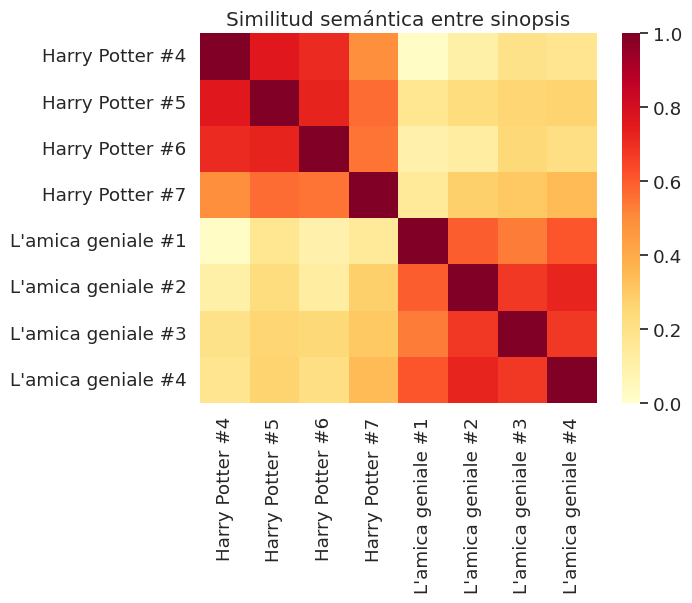

In [22]:
import tensorflow_hub as hub

# Cargamos el modelo de Universal Sentence Encoder
use_model = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')

# Codificamos las sinopsis en vectores (embeddings en un único tensor)
encoded_book_summaries = use_model(book_summaries)

# Se usa producto escalar al estar los embeddings normalizados
plot_similarity(encoded_book_summaries, titles, "Similitud semántica entre sinopsis", 90, np.inner)

Como vemos, el modelo de *Google* sí encuentra mayor relación entre los títulos de Harry Potter, sobre todo entre los tres primeros. También encuentra una discrepancia algo mayor entre el primer libro de la saga italiana respecto de los otros tres, sobre todo con el tercero. Los temas que se tratan en uno y en otro difieren, así como su tono.

Este modelo, al menos para este ejemplo en particular, captura muy bien los matices que a mi juicio existen entre libros de la misma saga.

---
Por tanto, a la hora de convertir las sinopsis en vectores que capturan el contenido semántico, podemos optar por el modelo reducido y eficiente, `all-MiniLM-L6-v2`, o el más preciso pero más complejo, `all-distilroberta-v1`, ofrecidos por SBERT; así como el modelo USE de Google. Ambos aportan resultados muy razonables, además de proceder de técnicas más punteras sobre NLP.

### Sentiment analysis

En el primer ejemplo de SBERT, obsérvabamos una relación por debajo de 0.5, pero no muy débil, entre *The Moon is a Harsh Mistress* y *Wuthering Heights*, libros a priori muy distintos. Es posible que la visceralidad del lenguaje empleado en la sinopsis de *Wuthering Heights*, sentimiento muy presente en la trama de dicha novela, podría haber influido en arrojar una similitud no tan baja respecto de *Harsh Mistress*. Lo cierto es que las sinopsis comparten un tono similar, y ambos libros incluyen un sentimiento de conflicto, latente a lo largo de las novelas.

Con esto, nos referimos a que las expresiones o tonalidades del lenguaje, en este caso usadas en las sinopsis, pueden jugar un papel interesante a la hora de tomar preferencia por un libro u otro. No sólo el contenido o la trama capturados de forma semántica, sino que el tono y las emociones desplegadas en las sinopsis (pero muy posiblemente presentes también en los libros) son otros aspectos a tener en cuenta a la hora de transformarlas en *inputs* para nuestro posterior modelo del sistema de recomendación. Un lector puede interesarse por un libro no sólo por su trama, sino también por su tono y estilo.

Así, podemos llevar a cabo un *sentiment analysis* de las sinopsis, como entrada alternativa/adicional del modelo recomendador. Utilizaremos de nuevo *Transformers*, pero esta vez a través de un modelo para clasificación de texto (multi-label) que podemos encontrar en [HuggingFace](https://huggingface.co/).

In [24]:
from transformers import pipeline

classifier = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=None)

model_outputs = classifier(book_summaries)
for model_output in model_outputs:
  print(model_output) # Lista de diccionarios para cada una de las etiquetas

[{'label': 'caring', 'score': 0.46986058354377747}, {'label': 'neutral', 'score': 0.215192973613739}, {'label': 'fear', 'score': 0.10201708972454071}, {'label': 'approval', 'score': 0.06941699236631393}, {'label': 'optimism', 'score': 0.06619422137737274}, {'label': 'nervousness', 'score': 0.06532858312129974}, {'label': 'realization', 'score': 0.040168631821870804}, {'label': 'joy', 'score': 0.0274391770362854}, {'label': 'relief', 'score': 0.02433866448700428}, {'label': 'excitement', 'score': 0.014521564356982708}, {'label': 'admiration', 'score': 0.013994812965393066}, {'label': 'sadness', 'score': 0.01131629291921854}, {'label': 'desire', 'score': 0.010408781468868256}, {'label': 'disapproval', 'score': 0.007435629144310951}, {'label': 'confusion', 'score': 0.006093436386436224}, {'label': 'annoyance', 'score': 0.004843660164624453}, {'label': 'pride', 'score': 0.004521148279309273}, {'label': 'disappointment', 'score': 0.0041668834164738655}, {'label': 'love', 'score': 0.00354110

En este modelo de clasificación de texto, se analizan 28 etiquetas de emociones y se les da un valor ponderado en función del peso que tienen dichas emociones. Se trata de un modelo basado en RoBERTa y entrenado con el dataset `go_emotions`, a partir de posts publicados en *Reddit*.

En cuanto a los resultados, es difícil determinar si el modelo acierta en detectar las emociones predominantes en las sinopsis. Por ejemplo, en los libros de *Harry Potter*, parece apreciar sentimientos como decepción, miedo, tristeza o confusión (los libros finales de la saga son algo más oscuros). Sobre la saga italiana, prácticamente asigna el mismo peso a los sentimientos que infiere de las sinopsis entre los cuatro libros.

Si queremos hacer una comparación de los libros a partir de los sentimientos, quizás convenga transformar estos resultados en un formato común, como un vector con los pesos de los sentimientos ordenados alfabéticamente.

tensor([[1.0000, 0.1462, 0.2385, 0.4384, 0.1468, 0.4436, 0.4410, 0.3920],
        [0.1462, 1.0000, 0.1530, 0.5875, 0.0742, 0.2560, 0.3386, 0.2559],
        [0.2385, 0.1530, 1.0000, 0.4394, 0.1188, 0.3914, 0.4368, 0.3872],
        [0.4384, 0.5875, 0.4394, 1.0000, 0.2191, 0.7945, 0.9174, 0.7914],
        [0.1468, 0.0742, 0.1188, 0.2191, 1.0000, 0.4783, 0.3095, 0.7009],
        [0.4436, 0.2560, 0.3914, 0.7945, 0.4783, 1.0000, 0.9503, 0.9221],
        [0.4410, 0.3386, 0.4368, 0.9174, 0.3095, 0.9503, 1.0000, 0.8900],
        [0.3920, 0.2559, 0.3872, 0.7914, 0.7009, 0.9221, 0.8900, 1.0000]],
       dtype=torch.float64)


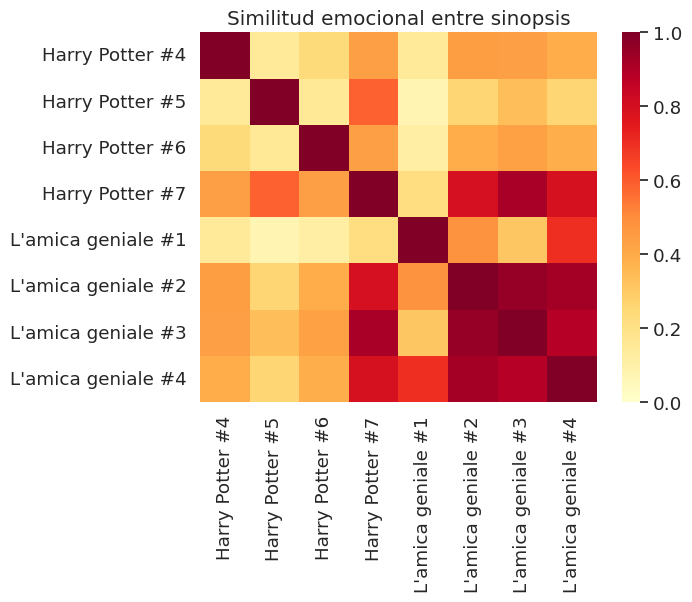

In [25]:
def sentiment_to_array(sentiment_lists):
  """
  Transforma una lista de diccionarios de sentiment analysis
  en un array con los valores de las emociones en orden alfabético
  """
  vectors = []
  for sentiment_list in sentiment_lists:
    label_score = [(sa['label'], sa['score']) for sa in sentiment_list]
    label_score.sort(key=lambda x: x[0])
    vectors.append([score for (label, score) in label_score])

  # Convierte los vectores en un array de NumPy
  sentiment_array = np.array(vectors)

  return sentiment_array

sentiment_array = sentiment_to_array(model_outputs)
plot_similarity(sentiment_array, titles, "Similitud emocional entre sinopsis", 90, util.cos_sim)

Una vez representada la similitud, esta vez basada en el *sentiment analysis* que hemos realizado sobre las sinopsis, observamos cómo en la saga de *L'amica geniale* sí hay una clara relación entre libros. Como comentábamos, el clasificador había detectado con casi el mismo peso los sentimientos predominantes en las sinopsis. Por el contrario, el caso de *Harry Potter* es mucho más difuso, e incluso encuentra mayor similitud entre libros de sagas distintas.

La conclusión que podemos sacar de esta técnica de comparación es que sinopsis de libros que son escritas con un estilo muy similar sí obtienen una relación directa elevada, pero al introducir variaciones no muy grandes los resultados pueden ser bastante dispares, al menos desde un punto de vista emocional.

Sin embargo, con este tipo de análisis, podemos incorporar al modelo del sistema recomendador una entrada adicional que se fije más en el componente emocional de las sinopsis y que complemente al *input* basado en el contexto y el significado de las mismas.

### TF-IDF (Term Frequency-Inverse Document Frequency)

Otra idea para transformar las sinopsis es la técnica tf-idf. Consiste en la obtención de las frecuencias de cada uno de los términos en las sinopsis (tf) junto con la frecuencia inversa de documento (idf). Esto último es un factor que tiene en cuenta la ocurrencia de términos muy frecuentes en toda la colección de documentos (en nuestro caso la colección de sinopsis), restándoles importancia, mientras que aquellos no tan frecuentes pero representativos del texto, son compensados.

Para las pruebas con esta técnica empleamos la conocida librería `sklearn` para extraer la información de las descripciones como un vector tf-idf. Después, representamos la matriz de similitudes como hemos estado haciendo en los anteriores ejemplos.

[[1.         0.40316307 0.2840623  0.14253497 0.11162708 0.16624657
  0.10994618 0.13594316]
 [0.40316307 1.         0.3512953  0.1752193  0.13680694 0.1641252
  0.11548913 0.13830488]
 [0.2840623  0.3512953  1.         0.23476126 0.23460977 0.26166006
  0.1809633  0.26290318]
 [0.14253497 0.1752193  0.23476126 1.         0.13557266 0.2168304
  0.15765722 0.22364452]
 [0.11162708 0.13680694 0.23460977 0.13557266 1.         0.40944585
  0.25504908 0.31507212]
 [0.16624657 0.1641252  0.26166006 0.2168304  0.40944585 1.
  0.3940217  0.4530717 ]
 [0.10994618 0.11548913 0.1809633  0.15765722 0.25504908 0.3940217
  1.         0.38293985]
 [0.13594316 0.13830488 0.26290318 0.22364452 0.31507212 0.4530717
  0.38293985 1.        ]]


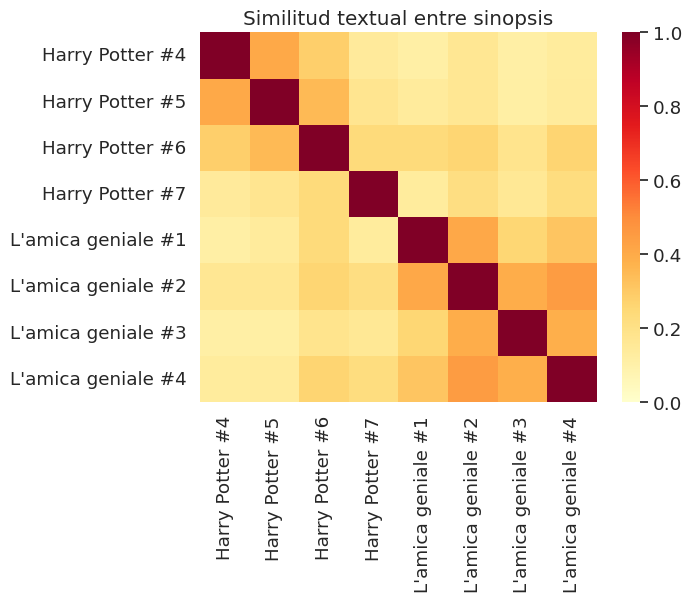

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Calcula los valores TF-IDF para las sinopsis
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(book_summaries)

# Mediante similitud coseno, se grafica la matriz de correlación
plot_similarity(tfidf_matrix, titles, "Similitud textual entre sinopsis", 90, cosine_similarity)

Como vemos, los resultados que obtenemos no son tan buenos como cabría esperar en base al contenido de las sinopsis. Sí encuentra algo de similitud entre los libros de una misma saga, pero esta se encuentra por debajo de 0.45, un valor bastante pobre que nos advierte de una relación directa débil.

Esto puede deberse a que la colección de documentos es más bien de juguete, en el sentido de que para el cálculo de la frecuencia inversa de documento, son muy pocos los documentos como para tener una idea global de qué términos desechar y qué otros tener en cuenta dándoles un mayor peso.

Es probable que haciendo pruebas a una escala mayor, por ejemplo sobre las sinopsis en inglés del dataset de libros, obtengamos mejores resultados.

In [27]:
import pandas as pd
from ast import literal_eval

books_df = pd.read_csv('https://raw.githubusercontent.com/malcolmosh/goodbooks-10k/master/books_enriched.csv', index_col=[0], converters={"genres": literal_eval})

In [28]:
# Selección de las sinopsis en inglés
books_df_summaries = books_df[(books_df['description'].notna()) & (books_df['language_code'] == 'eng')]['description']
books_df_summaries.head(10)

0    WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...
1    Harry Potter's life is miserable. His parents ...
2    About three things I was absolutely positive.\...
3    The unforgettable novel of a childhood in a sl...
4    Alternate Cover Edition ISBN: 0743273567 (ISBN...
5    Despite the tumor-shrinking medical miracle th...
6    In a hole in the ground there lived a hobbit. ...
7    The hero-narrator of The Catcher in the Rye is...
8    World-renowned Harvard symbologist Robert Lang...
9    Alternate cover edition of ISBN 9780679783268S...
Name: description, dtype: object

[[1.         0.49564806 0.30904894 0.17196507 0.02739848 0.05061208
  0.03252401 0.03478178]
 [0.49564806 1.         0.37852994 0.19483061 0.04768266 0.05073183
  0.05634641 0.04170214]
 [0.30904894 0.37852994 1.         0.20762911 0.05688498 0.06938891
  0.05203324 0.06454561]
 [0.17196507 0.19483061 0.20762911 1.         0.03663356 0.07100857
  0.04770675 0.06478857]
 [0.02739848 0.04768266 0.05688498 0.03663356 1.         0.34743531
  0.1991048  0.21200844]
 [0.05061208 0.05073183 0.06938891 0.07100857 0.34743531 1.
  0.36779593 0.34496761]
 [0.03252401 0.05634641 0.05203324 0.04770675 0.1991048  0.36779593
  1.         0.31978898]
 [0.03478178 0.04170214 0.06454561 0.06478857 0.21200844 0.34496761
  0.31978898 1.        ]]


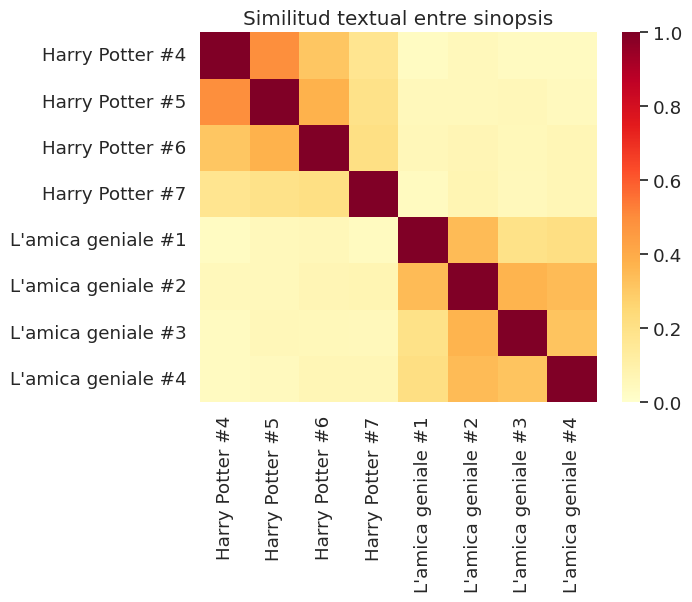

In [29]:
# Cálculo del vector TF-IDF adecuándose al dataset
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(books_df_summaries)

# Representación TF-IDF de las sinopsis de ejemplo
tfidf_matrix = tfidf_vectorizer.transform(book_summaries)

# Mediante similitud coseno, se grafica la matriz de correlación
plot_similarity(tfidf_matrix, titles, "Similitud textual entre sinopsis", 90, cosine_similarity)

Como podemos observar, los resultados de similitud entre distintas sagas sí son bastante buenos, pues se obtienen valores muy próximos al 0, los cuales nos indican la gran diferencia que existe entre ellas. El problema llega cuando se comparan libros de una misma saga, y es que apenas se detecta una relación directa entre estos.

Por tanto, este método de vectorización puede servirnos para saber qué libros son incompatibles con otros (tienen una similitud coseno menor que un umbral que podemos establecer), pero no mucho para encontrar libros que compartan características en base a sus sinopsis.